In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import statsmodels.api as sm

%matplotlib inline

In [259]:
plt.rc('figure', figsize=(18.0, 6.0))

## Load files

Selected dataid 4874 as initial building to test out

In [528]:
df_4874 = pickle.load(open('pickle_files/df_4874.p', 'rb'))
df_4874 = df_4874.sort_values('localhour', ascending=True)
df_4874.index = df_4874.apply(strip_tz, axis=1)

In [531]:
#set time period to October 2016
df_4874 = df_4874.loc['2016-10-01 00:00:00':'2016-11-01 00:00:00',:]

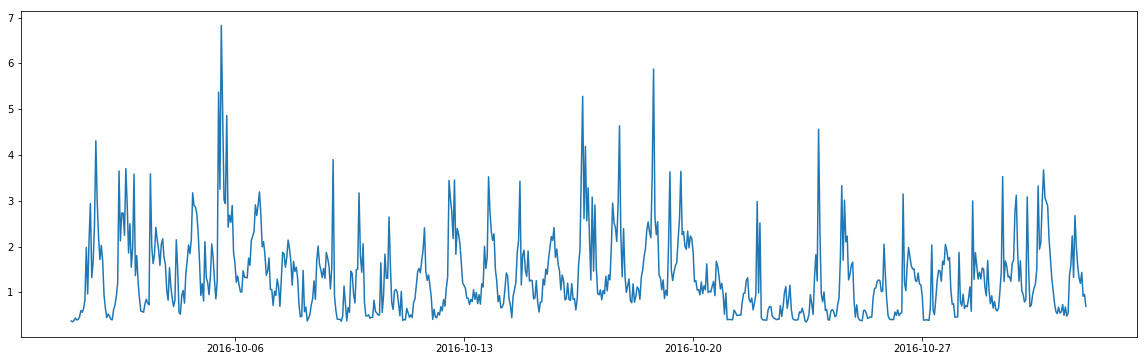

In [532]:
#plot electricity usage 
plt.subplots(1,1,figsize=(20,6))
plt.plot(df_4874.localhour, df_4874.use)

## AR models

In [590]:
#function to plot AR time series model with actual usage
def plot_ar_model(model, pred_start, name):

    x = df_4874.localhour
    y_true = df_4874.use
    
    #plot actual usage
    plt.subplots(1,1,figsize=(20,6))
    plt.plot(x,y_true, label='actual usage')
    

    x_pred = x[pred_start:]
    y_pred = model.predict()

    
    #plot model prediction with AR
    plt.plot(x_pred,y_pred, color='red', label='predicted usage')

    plt.title("Electricity Usage of Building 4874 in April 2017 {}".format(name))
    plt.xlabel("Date")
    plt.ylabel("Electricity Consumption (kWh)")
    # plt.yscale('log')
    plt.legend()

AR1

In [583]:
#hourly_usage must be converted to list
AR1_model = sm.tsa.AR(df_4874.use, freq="H").fit(maxlag=1)
print(AR1_model.params)

const     0.457153
L1.use    0.666269
dtype: float64


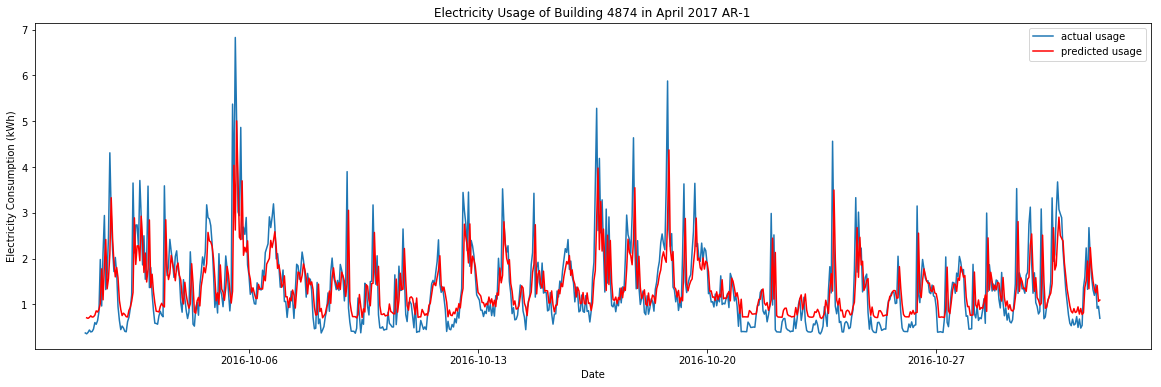

In [584]:
plot_ar_model(AR1_model, 1, 'AR-1')

AR2

In [601]:
AR2_model= sm.tsa.AR(df_4874.use, freq="H").fit(maxlag=2)
print(AR2_model.params)

const     0.358991
L1.use    0.520039
L2.use    0.218357
dtype: float64


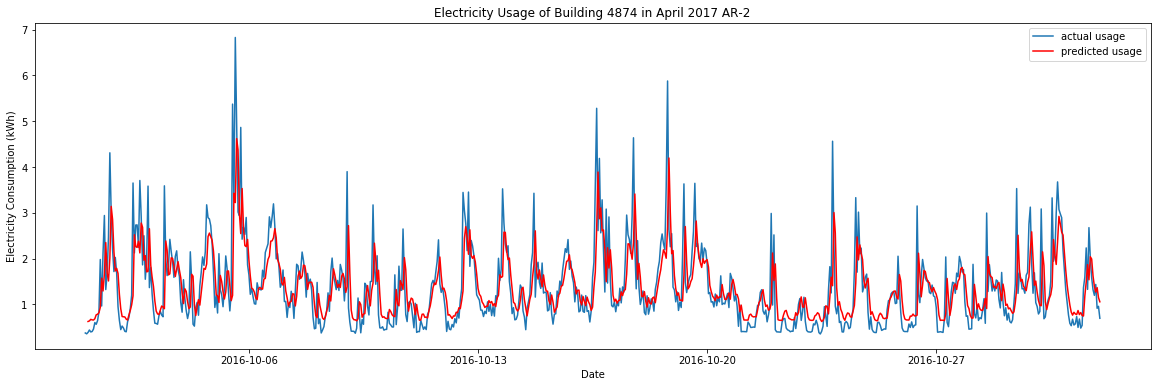

In [603]:
plot_ar_model(AR2_model, 2, 'AR-2')

AR3

In [604]:
AR3_model = sm.tsa.AR(df_4874.use, freq="H").fit(maxlag=3)
print(AR3_model.params)

const     0.339742
L1.use    0.507329
L2.use    0.188418
L3.use    0.056968
dtype: float64


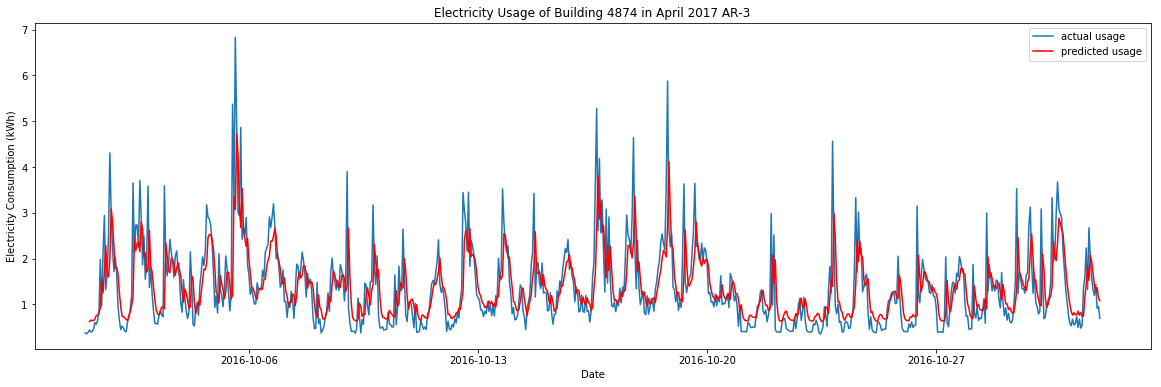

In [605]:
plot_ar_model(AR3_model, 3, 'AR-3')

## MA models

In [606]:
#function to plot MA time series model with actual usage
def plot_ma_model(y_select, name):

    x = df_4874.localhour
    y_true = df_4874.use

    #plot actual usage
    plt.subplots(1,1,figsize=(20,6))
    plt.plot(x,y_true, label='actual usage')

    x_pred = x
    y_pred = y_select

    #plot model prediction with MA10
    plt.plot(x_pred,y_pred, color='red', label='predicted usage')

    plt.title("Electricity Usage of Building 4874 in April 2017 {}".format(name))
    plt.xlabel("Date")
    plt.ylabel("Electricity Consumption (kWh)")
    # plt.yscale('log')
    plt.legend()

Moving Average (MA)

In [641]:
#create new dataframe with time as index
df_4874_new = pd.DataFrame(df_4874.use)
df_4874_new["Hourly_Usage_MA10"] = pd.stats.moments.rolling_mean(df_4874_new, window=10, center=True)
df_4874_new.index = df_4874.apply(strip_tz, axis=1)
df_4874_new = df_4874_new.rename(columns={'use':'Hourly_Usage'})
df_4874_new.index = pd.to_datetime(df_4874_new.index)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=True).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


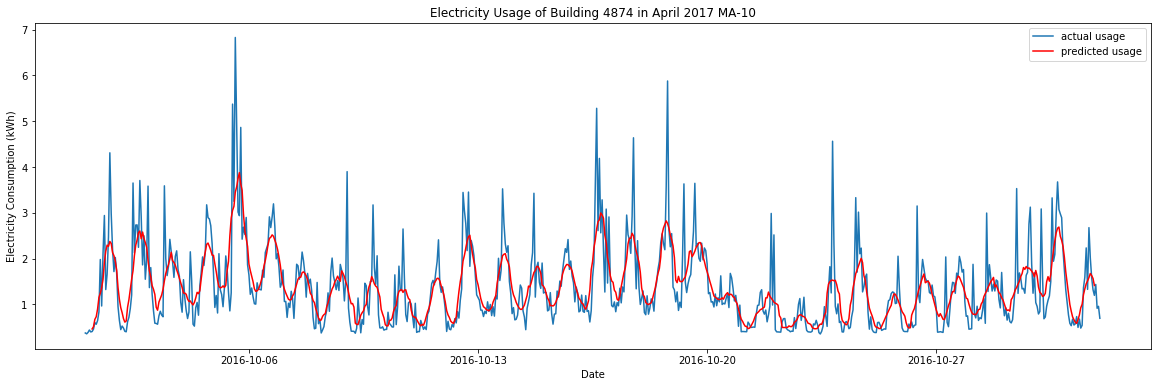

In [642]:
plot_ma_model(df_4874_new["Hourly_Usage_MA10"], 'MA-10')

EWMA

In [643]:
ewma= pd.stats.moments.ewma(df_4874_new, halflife=5)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(min_periods=0,ignore_na=False,adjust=True,halflife=5).mean()
  """Entry point for launching an IPython kernel.


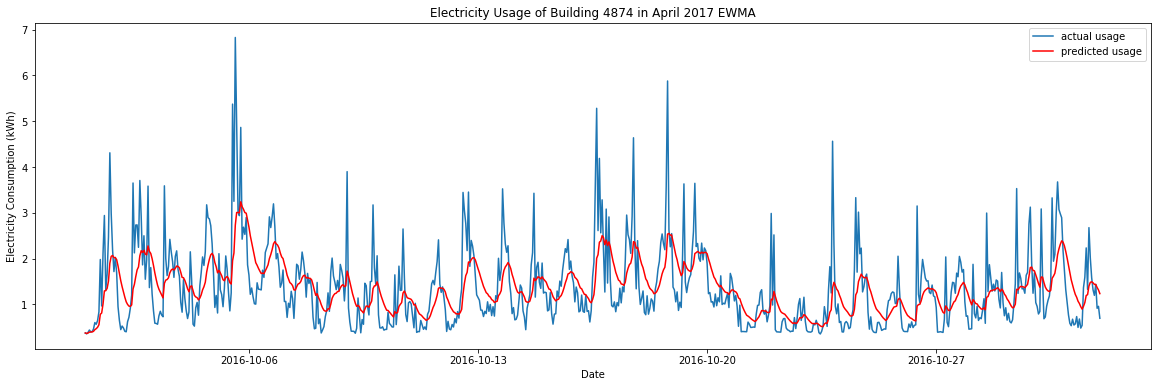

In [644]:
plot_ma_model(ewma['Hourly_Usage'], 'EWMA')

## ARIMA models

In [645]:
import itertools
import seasonal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

### Explore model

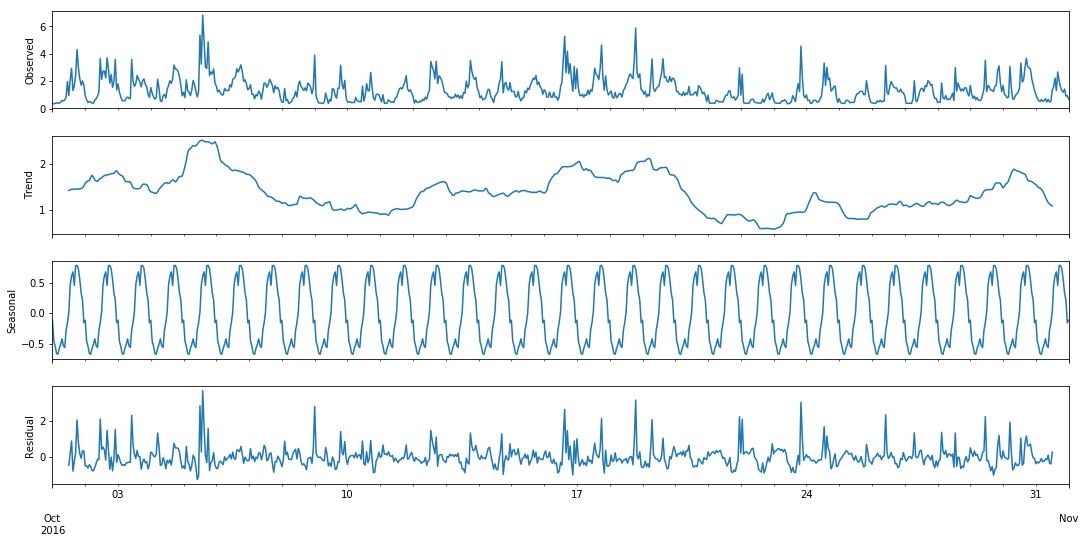

In [640]:
#plot seasonal decomposition
decomposition = seasonal_decompose(df_4874_new.Hourly_Usage, freq=24)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

In [646]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [647]:
#function to test stationarity
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=24)
    rolstd = pd.rolling_std(timeseries, window=24)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  


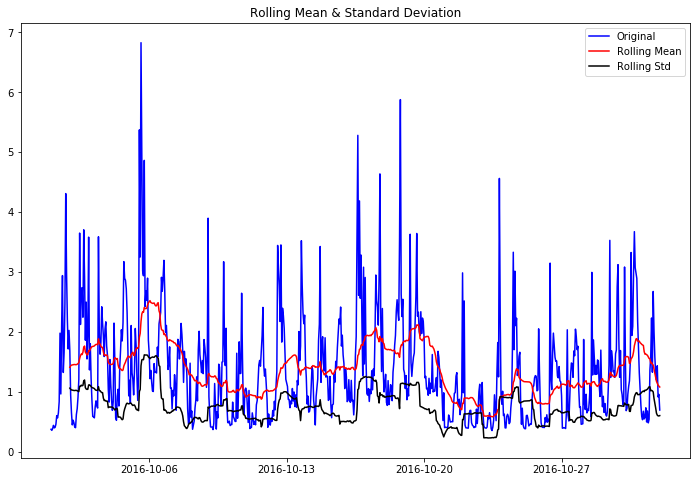

Results of Dickey-Fuller Test:
Test Statistic                  -2.893633
p-value                          0.046093
#Lags Used                      20.000000
Number of Observations Used    724.000000
Critical Value (1%)             -3.439414
Critical Value (5%)             -2.865540
Critical Value (10%)            -2.568900
dtype: float64


In [648]:
test_stationarity(df_4874_new.Hourly_Usage)

Original time series was already stationary

In [652]:
df_4874_new['first_difference'] = df_4874_new.Hourly_Usage - df_4874_new.Hourly_Usage.shift(1)
# test_stationarity(df_4874_new.first_difference)

In [653]:
df_4874_new['seasonal_difference'] = df_4874_new.Hourly_Usage - df_4874_new.Hourly_Usage.shift(24)
# test_stationarity(df_4874_new.seasonal_difference)

In [654]:
df_4874_new['seasonal_first_difference'] = df_4874_new.first_difference - df_4874_new.first_difference.shift(24)
# test_stationarity(df_4874_new.seasonal_first_difference)

PACF and ACF charts

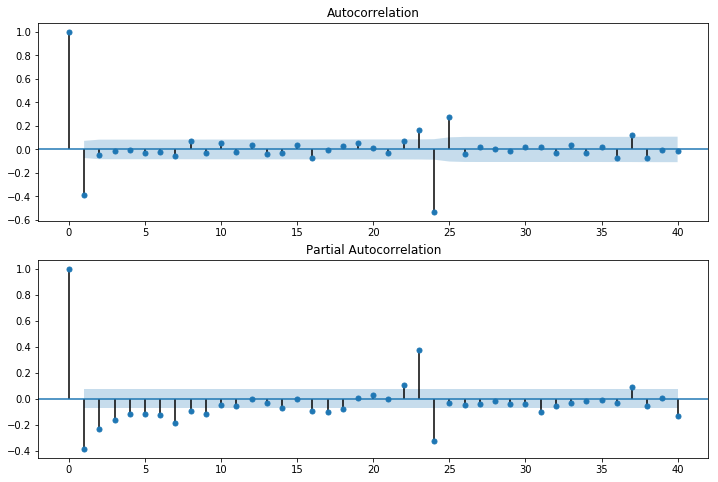

In [655]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_4874_new.seasonal_first_difference.iloc[25:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_4874_new.seasonal_first_difference.iloc[25:], lags=40, ax=ax2)

### Optimize order and seasonal order parameters in SARIMAX model

In [656]:
from datetime import datetime
from dateutil.relativedelta import *
import statsmodels.tsa.api as smt
import seaborn as sns

In [657]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 1, 0, 24)
SARIMAX: (0, 1, 0) x (0, 1, 1, 24)
SARIMAX: (0, 1, 0) x (1, 0, 0, 24)


In [882]:
#function to find optimal parameters and resulting AIC score
def gridsearch_arima(y, exog=None):
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

    low_aic = [0,0,50000]
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(y,
                                                  exog=exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = model.fit()
                if results.aic < low_aic[2]:
                    low_aic = [param, param_seasonal, results.aic]

#                 print('ARIMA{}x{}24 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return low_aic

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

In [1080]:
#function to create training and testing set
def create_train_test(data, start_train, end_train, start_test, end_test):
    df_train = data.loc[start_train:end_train, :]
    df_test = data.loc[start_test:end_test, :]
    
    start = datetime.strptime(start_test, '%Y-%m-%d %H:%M:%S')
    date_list = [start + relativedelta(hours=x) for x in range(0,24)]
    future = pd.DataFrame(index=date_list, columns= df_train.columns)
    df_train = pd.concat([df_train, future])
    
    return df_train, df_test

In [1108]:
df_4874_train, df_4874_test = create_train_test(df_4874_new,'2016-10-01 00:00:00','2016-10-30 00:00:00',
                                               '2016-10-30 01:00:00','2016-10-31 00:00:00')

In [1109]:
y_train = df_4874_train.Hourly_Usage
low_aic_1 = gridsearch_arima(y_train)

In [1083]:
low_aic_1

[(1, 0, 1), (0, 1, 1, 24), 1236.1592943448386]

In [1110]:
arima_1 = sm.tsa.statespace.SARIMAX(y_train,
                                  trend=None,
                                  order=low_aic_1[0],
                                  seasonal_order=low_aic_1[1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = arima_1.fit()

In [1085]:
print(results.params)

ar.L1       0.851799
ma.L1      -0.493441
ma.S.L24   -0.912977
sigma2      0.373973
dtype: float64


In [1086]:
# define helper plot function for visualization
def acf_pacf_plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

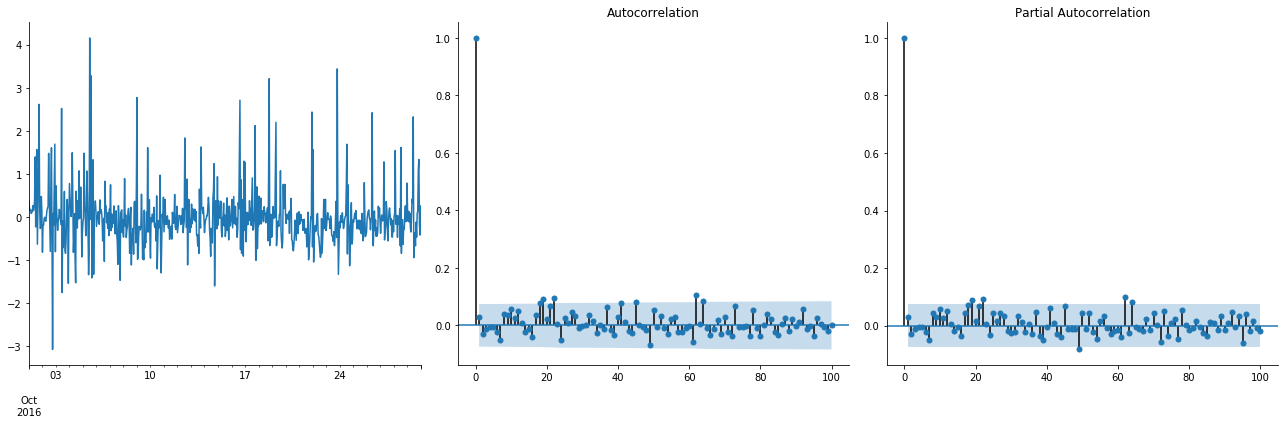

In [1087]:
acf_pacf_plots(results.resid.dropna(), lags=100)

In [1037]:
from sklearn.metrics import mean_squared_error

In [1115]:
#function to forecast with fitted model
def add_forecast(model, test, train, start_time, end_time):
    
    train['forecast'] = model.predict(start=start_time, end=end_time)
    y_true = test.loc[start_time:end_time, 'Hourly_Usage']
    y_pred = train.loc[start_time:end_time, 'forecast']
    train.loc[start_time:end_time, 'Hourly_Usage'] = test.loc[start_time:end_time, 'Hourly_Usage']
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mse, rmse

In [1116]:
def plot_forecast(data, datapoints):
    fig = plt.figure(figsize=(16,8))
    plt.plot(data['Hourly_Usage'][datapoints:])
    plt.plot(data['forecast'])
    plt.legend()

(0.70748085589769516, 0.84111881199845673)


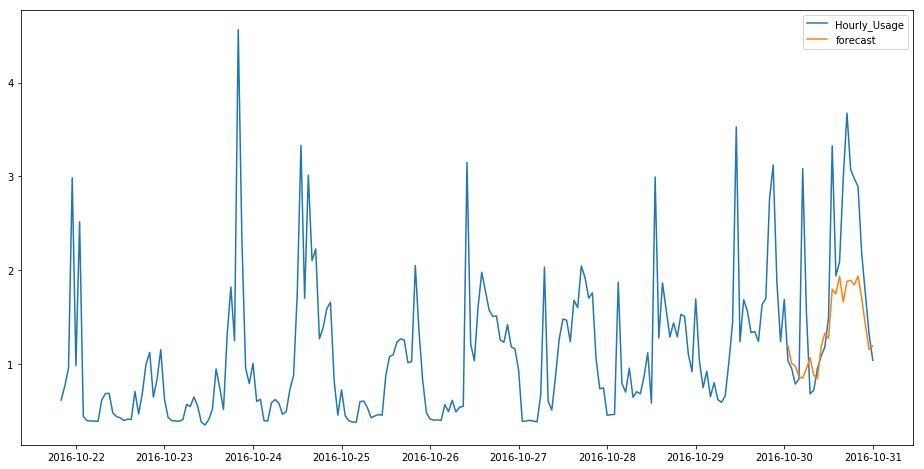

In [1118]:
print(add_forecast(results, df_4874_test, df_4874_train,'2016-10-30 01:00:00','2016-10-31 00:00:00'))
plot_forecast(df_4874_train, 500)

### Add exogenous variables to SARIMAX model

Ideas: hour of day, sleep hours, day of week (work day), weather
- will need to do a lot of feature engineering

In [1119]:
type(df_4874_new.index[0])

pandas._libs.tslib.Timestamp

In [1120]:
type(df_weather_austin['localhour'][0])

datetime.datetime

In [1121]:
y_train.index.hour

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', length=721)

In [733]:
df_weather_austin = pickle.load(open('weather_austin.p', 'rb'))
df_weather_austin = df_weather_austin.sort_values('localhour', ascending=True)
df_weather_austin.index =pd.to_datetime(df_weather_austin.apply(strip_tz, axis=1))

In [1122]:
#function to indicate weekends
def is_weekend(row):
    if row['Day_of_Week'] > 4:
        return 1
    else:
        return 0  

In [1123]:
#function to indicate sleep hours
def is_sleep(row):
    if row['Hour'] < 7:
        return 1
    else:
        return 0

In [1124]:
#function to strip timezone from datetime
def strip_tz(row):
    return row['localhour'].strftime('%Y-%m-%d %H:%M:%S')

In [1125]:
#function to add all exogenous variables
def add_exog(data, start_time, end_time):
    
    data['Day_of_Week'] = data.index.dayofweek
    data['Weekend'] = data.apply(is_weekend, axis=1)
    data['Temperature'] = df_weather_austin.loc[start_time:end_time, 'temperature']
    
    return data

In [1145]:
df_4874_exog = add_exog(df_4874_train, '2016-10-01 00:00:00', '2016-10-31 00:00:00')

#fill missing temperature values
df_4874_exog['Temperature'] = df_4874_train.Temperature.fillna(np.mean(df_4874_train['Temperature']))

exogenous = df_4874_exog.loc['2016-10-01 00:00:00':,['Weekend','Temperature']].astype(float)
endogenous = df_4874_exog.loc[:,'Hourly_Usage'].astype(float)
exogenous.shape, endogenous.shape

In [1147]:
gridsearch_arima(endogenous,exogenous)

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 1), (0, 1, 1, 24), 1275.3275604050395]

In [1148]:
arima_2 = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                  exog = exogenous,
                                  trend=None,
                                  order=(1, 0, 1),
                                  seasonal_order=(0, 1, 1, 24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results_2 = arima_2.fit()

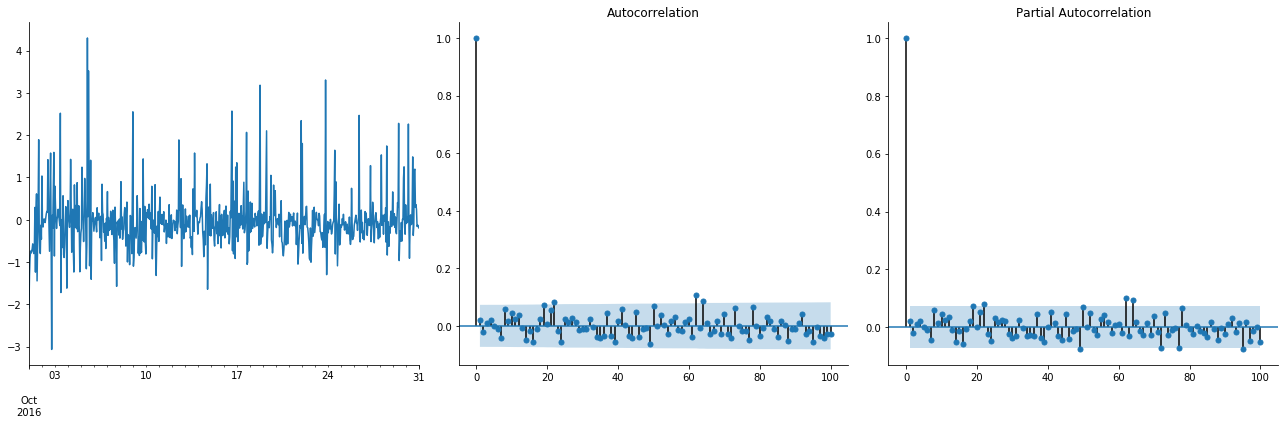

In [1149]:
acf_pacf_plots(results_2.resid.dropna(), lags=100)

In [1150]:
results.aic, results_2.aic

(1236.1592943448386, 1275.3275604050395)

Worse AIC score but let's see if the MSE is better

In [1155]:
df_4874_exog_train, df_4874_exog_test = create_train_test(df_4874_exog,'2016-10-01 00:00:00','2016-10-30 00:00:00',
                                               '2016-10-30 01:00:00','2016-10-31 00:00:00')

(0.48780565223530076, 0.69843085000256167)


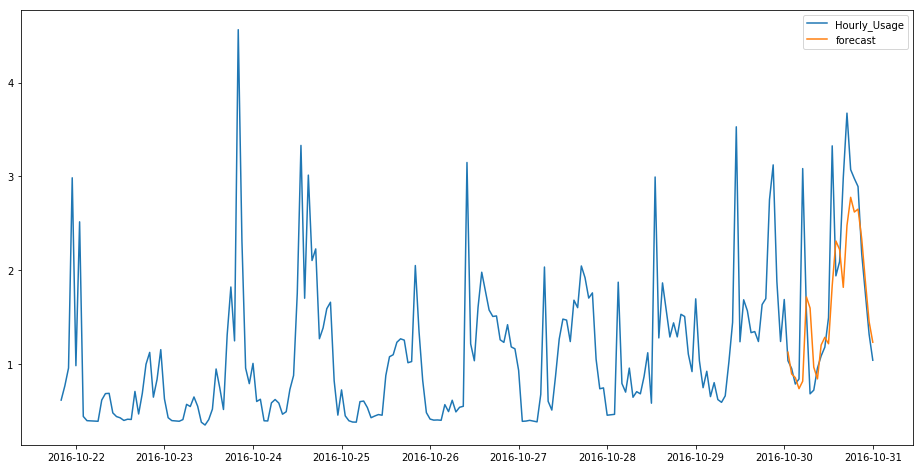

In [1156]:
print(add_forecast(results_2, df_4874_exog_test, df_4874_exog_train,'2016-10-30 01:00:00','2016-10-31 00:00:00'))
plot_forecast(df_4874_exog_train, 500)

Improvements in MSE with exogenous variables! Maybe add more

-------

## Holt-Winters... don't know if it works very well with this data...

In [44]:
import seasonal as hw

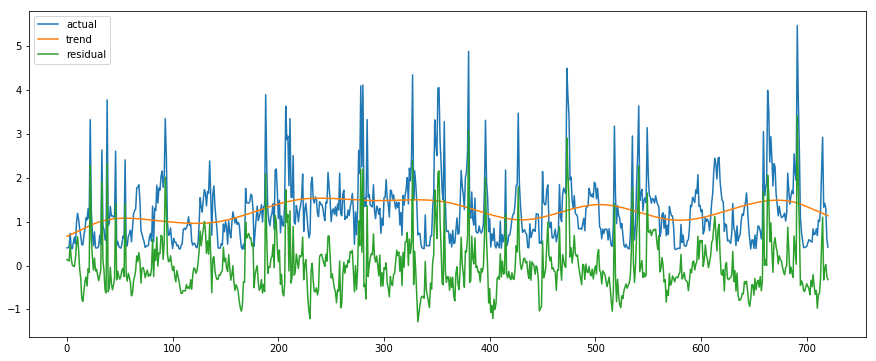

In [45]:
seasons, trend = hw.fit_seasons(y_true)
adjusted = hw.adjust_seasons(y_true, seasons=seasons)
residual = adjusted - trend
plt.subplots(1,1, figsize=(15,6))
plt.plot(y_true, label='actual')
plt.plot(trend, label='trend')
plt.plot(residual, label='residual')
plt.legend()

## Clustering buildings

In [323]:
pd.set_option('display.max_columns', None) 

In [33]:
df_metadata= pd.read_csv('dataport-metadata.csv')
df_metadata.head()

dataid active_record       building_type program_579 program_baseline  \
0    2836           NaN  Single-Family Home         NaN              NaN   
1    2743           NaN  Single-Family Home         NaN              NaN   
2    5323           NaN  Single-Family Home         NaN              yes   
3    8560           NaN  Single-Family Home         NaN              yes   
4    3313           NaN  Single-Family Home         NaN              yes   

  program_energy_internet_demo program_lg_appliance program_verizon  \
0                          yes                  NaN             NaN   
1                          yes                  NaN             NaN   
2                          yes                  NaN             NaN   
3                          yes                  NaN             NaN   
4                          yes                  NaN             NaN   

  program_ccet_group program_civita_group    city  state   pv date_enrolled  \
0                NaN                  NaN  Austin  Texas  NaN    2011-02-01   
1                NaN                  NaN  Austin  Texas  NaN    2011-02-01   
2                NaN                  NaN  Austin  Texas  NaN    2011-02-01   
3                NaN                  NaN  Austin  Texas  NaN    2011-02-01   
4                NaN                  NaN  Austin  Texas  NaN    2011-02-01   

  date_withdrawn  house_construction_year  total_square_footage  \
0     2011-03-19                   1994.0                2796.0   
1     2011-09-01                   1949.0                1590.0   
2     2011-11-29                   2008.0                1185.0   
3     2012-02-01                   2009.0                2001.0   
4     2012-04-30                   2007.0                2001.0   

   first_floor_square_footage  second_floor_square_footage  \
0                      1476.0                       1320.0   
1                      1590.0                          0.0   
2                       602.0                        583.0   
3                      1435.0                        566.0   
4                      1435.0                        566.0   

   third_floor_square_footage  half_floor_square_footage  \
0                         0.0                        NaN   
1                         0.0                        NaN   
2                         0.0                        NaN   
3                         0.0                        NaN   
4                         0.0                        NaN   

   lower_level_square_footage audit_2011 audit_2013_2014 survey_2011  \
0                         NaN                                          
1                         NaN                                    yes   
2                         NaN        yes                               
3                         NaN        yes                         yes   
4                         NaN        yes                         yes   

  survey_2012 survey_2013 survey_2014  number_of_nests indoor_temp_min_time  \
0                     yes                          NaN                  NaN   
1                                                  NaN                  NaN   
2                                                  NaN                  NaN   
3                                                  NaN                  NaN   
4                                                  NaN                  NaN   

  indoor_temp_max_time gas_ert_min_time gas_ert_max_time water_ert_min_time  \
0                  NaN              NaN              NaN                NaN   
1                  NaN              NaN              NaN                NaN   
2                  NaN              NaN              NaN                NaN   
3                  NaN              NaN              NaN                NaN   
4                  NaN              NaN              NaN                NaN   

  water_ert_max_time egauge_min_time egauge_max_time  use grid  gen air1 air2  \
0                NaN             NaN       

In [44]:
df_metadata[(df_metadata.house_construction_year > 0) & 
            (df_metadata.total_square_footage > 0) &
           (df_metadata.city == 'Austin')]

dataid active_record       building_type program_579 program_baseline  \
0       2836           NaN  Single-Family Home         NaN              NaN   
1       2743           NaN  Single-Family Home         NaN              NaN   
2       5323           NaN  Single-Family Home         NaN              yes   
3       8560           NaN  Single-Family Home         NaN              yes   
4       3313           NaN  Single-Family Home         NaN              yes   
5       5052           NaN  Single-Family Home         NaN              yes   
6       3936           NaN  Single-Family Home         NaN              yes   
7       1622           NaN           Town Home         NaN              yes   
8       1114           NaN  Single-Family Home         NaN              yes   
9       5433           NaN  Single-Family Home         NaN              yes   
10      1101           NaN  Single-Family Home         NaN              yes   
11      8872           NaN  Single-Family Home         NaN              yes   
12      1464           NaN  Single-Family Home         NaN              yes   
13      3824           NaN  Single-Family Home         NaN              yes   
14        78           NaN  Single-Family Home         NaN              yes   
15      8047           NaN  Single-Family Home         NaN              yes   
16      5839           NaN  Single-Family Home         NaN              yes   
17      1050           NaN  Single-Family Home         NaN              yes   
18      8597           NaN  Single-Family Home         NaN              yes   
19      7982           NaN  Single-Family Home         NaN              yes   
20      7057           NaN  Single-Family Home         NaN              yes   
21      3192           NaN  Single-Family Home         NaN              yes   
22      1790           NaN  Single-Family Home         NaN              yes   
23      3577           NaN  Single-Family Home         NaN              yes   
24        18           yes  Single-Family Home         NaN              yes   
25        35           yes  Single-Family Home         NaN              yes   
26       114           yes  Single-Family Home         NaN              yes   
27       370           yes  Single-Family Home         NaN              yes   
28       545           yes  Single-Family Home         NaN              yes   
29       585           yes  Single-Family Home         NaN              yes   
30       661           yes  Single-Family Home         NaN              yes   
32       964           yes  Single-Family Home         NaN              yes   
33      1185           yes  Single-Family Home         NaN              yes   
34      1192           yes  Single-Family Home         NaN              yes   
35      1463           yes  Single-Family Home         NaN              yes   
36      1642           yes  Single-Family Home         NaN              yes   
37      1718           yes  Single-Family Home         NaN              yes   
38      1800           yes  Single-Family Home         NaN              yes   
39      1801           yes  Single-Family Home         NaN              yes   
40      1852           yes           Town Home         NaN              yes   
41      2018           yes  Single-Family Home         NaN              yes   
42      2129           yes  Single-Family Home         NaN              yes   
43      2233           yes  Single-Family Home         NaN              yes   
44      2335           yes  Single-Family Home         NaN              yes   
45      2337           yes  Single-Family Home         NaN              yes   
46      2345           yes           Town Home         NaN              yes   
47      2461           yes  Single-Family Home         NaN              yes   
48      2575           yes  Single-Family Home         NaN              yes   
49      2638           yes           Town Home         NaN              yes   
50      2645           yes  Single-Family Home         N